# Multi-layer Perceptron (MLP)

- **Training set**: LO_SARD102 (0.75 split)
- **Test/Validation set:** LO_SARD102 (0.25 split)
- **Features**: word2vec average
- **Class imbalance processing**: SMOTE Oversampling

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/home/scheuererra68323/venv37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load labeled dataset

In [2]:
dataset = pd.read_hdf("/mnt/md0/user/scheuererra68323/LO_SARD102/LO_SARD102_word2vec.h5")
print(dataset.shape)
print(dataset.is_vulnerable.value_counts())

(292724, 2)
0.0    269721
1.0     23003
Name: is_vulnerable, dtype: int64


## Split dataset into training and test

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset.word2vec_avg,
    dataset.is_vulnerable,
    test_size=0.2,
    stratify=dataset.is_vulnerable,
    random_state=0
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train,
    Y_train,
    test_size=0.25,
    stratify=Y_train,
    random_state=1
)

X_train = numpy.stack(X_train, axis=0)
Y_train = numpy.stack(Y_train, axis=0)
X_val = numpy.stack(X_val, axis=0)
Y_val = numpy.stack(Y_val, axis=0)
X_test = numpy.stack(X_test, axis=0)
Y_test = numpy.stack(Y_test, axis=0)

print("Training Set:")
print(f"{len(X_train)} total")
print(Counter(Y_train))
print()      
print("Validation Set:")
print(f"{len(X_val)} total")
print(Counter(Y_val))
print()      
print("Test Set:")
print(f"{len(X_test)} total")
print(Counter(Y_test))

Training Set:
175634 total
Counter({0.0: 161833, 1.0: 13801})

Validation Set:
58545 total
Counter({0.0: 53944, 1.0: 4601})

Test Set:
58545 total
Counter({0.0: 53944, 1.0: 4601})


## Apply SMOTE

In [4]:
X_train, Y_train = oversample_smote(X_train, Y_train)

imbalanced_learn version  0.7.0
Counter output before SMOTE: Counter({0.0: 161833, 1.0: 13801})
Counter output after SMOTE: Counter({0.0: 161833, 1.0: 161833})


## Model definition & Training

In [5]:
init_mode = 'glorot_uniform'
model = keras.Sequential(
    [
        layers.Dense(64,
                     input_dim=100,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),

        layers.Dropout(0.1),

        layers.Dense(64,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),

        layers.Dense(64,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),

        layers.Dense(1, 
                     kernel_initializer=init_mode, 
                     activation=tf.nn.sigmoid),
    ]
)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=0.001),
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=X_train.shape[0],
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, Y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________
Train on 323666 samples, validate on 58545 samples
Epoch 1/100
323666/323666 [==============================] - 2s 5us

Epoch 48/100
323666/323666 [==============================] - 0s 1us/sample - loss: 0.1676 - accuracy: 0.9357 - val_loss: 0.1444 - val_accuracy: 0.9478
Epoch 49/100
323666/323666 [==============================] - 0s 1us/sample - loss: 0.1655 - accuracy: 0.9364 - val_loss: 0.1495 - val_accuracy: 0.9468
Epoch 50/100
323666/323666 [==============================] - 0s 1us/sample - loss: 0.1634 - accuracy: 0.9377 - val_loss: 0.1386 - val_accuracy: 0.9511
Epoch 51/100
323666/323666 [==============================] - 0s 1us/sample - loss: 0.1607 - accuracy: 0.9394 - val_loss: 0.1360 - val_accuracy: 0.9517
Epoch 52/100
323666/323666 [==============================] - 0s 1us/sample - loss: 0.1593 - accuracy: 0.9400 - val_loss: 0.1429 - val_accuracy: 0.9496
Epoch 53/100
323666/323666 [==============================] - 0s 1us/sample - loss: 0.1570 - accuracy: 0.9404 - val_loss: 0.1357 - val_accuracy: 0.9518
Epoch 54/100
323666/323666 [==============================] - 0s 1us/sample - loss: 0.15

## Evaluation

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     53944
         1.0       0.71      0.97      0.82      4601

    accuracy                           0.97     58545
   macro avg       0.85      0.97      0.90     58545
weighted avg       0.97      0.97      0.97     58545

Confusion matrix:
[[52130  1814]
 [  161  4440]]

Confusion matrix (Percentages):
[[89.043  3.098]
 [ 0.275  7.584]]

Metrics:
Sensitivity (TPR): 0.965008
Specifity (TNR):   0.966373

FPR: 0.033627
FNR: 0.034992

Balanced accuracy: 0.965690

Test loss:	0.096863
Test accuracy:	0.966265


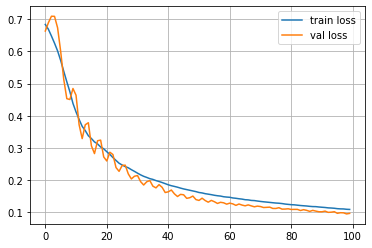

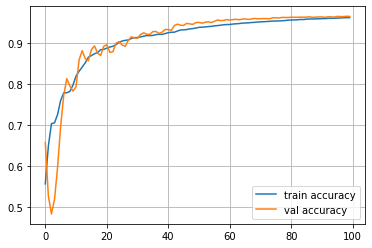

In [6]:
Y_pred = numpy.round(model.predict(X_test))

print(classification_report(Y_test, Y_pred))
print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
print()
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

plot_loss(history)
plot_accuracy(history)

Slightly higher FPR and there in favor of a higher Sensitivity (TPR)

In [7]:
model.save('MLP_word2vec_SMOTE_variant1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP_word2vec_SMOTE_variant1/assets
